In [1]:
import catboost as cb
import gc
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import warnings
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [3]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"

In [5]:
%load_ext autoreload
%autoreload

### Read Data

In [6]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_agg_exp.pkl")

Shape of data: (458913, 4648)
CPU times: user 3.5 s, sys: 10.2 s, total: 13.7 s
Wall time: 19.8 s


In [7]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


### Pre-train Feature Reduction

In [8]:
def select_noob_features(feature_imp_df, threshold):
    noob_features = []
    for type_ in feature_imp_df.columns[1:]:
        noob_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    print(len(noob_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return noob_features

In [9]:
def get_feature_imp_percentile(summary_df, p):
    array = pd.Series(np.stack(summary_df.drop(columns="base_feature", errors="ignore").values).ravel()).dropna().values
    return np.percentile(array, p)

In [10]:
features_to_drop = set()
for i, threshold_percentile in zip(range(5), range(5)):
    print(f"Read file {i}")
    summary_feature_imp = read_file(f"{EXP_PATH}/feature_imp_summary{i}.csv")
    # feature_imp_thr = get_feature_imp_percentile(summary_feature_imp, threshold_percentile)
    feature_imp_thr = 7
    drop_feature_subset = set(select_noob_features(summary_feature_imp, feature_imp_thr))
    features_to_drop = features_to_drop.union(drop_feature_subset)
    print(f"Threshold = {feature_imp_thr:.2f}, Dropping # of features {len(drop_feature_subset)}")

Read file 0
Shape of data: (181, 49)
1131 8688
Threshold = 7.00, Dropping # of features 1131
Read file 1
Shape of data: (176, 25)
582 4224
Threshold = 7.00, Dropping # of features 582
Read file 2
Shape of data: (188, 25)
1551 4512
Threshold = 7.00, Dropping # of features 1551
Read file 3
Shape of data: (163, 25)
823 3912
Threshold = 7.00, Dropping # of features 823
Read file 4
Shape of data: (140, 25)
108 3360
Threshold = 7.00, Dropping # of features 108


In [11]:
len(features_to_drop)

3098

In [12]:
train_agg = train_agg.drop(columns=list(features_to_drop), errors="ignore")

In [13]:
target = labels["target"].values

In [14]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
gc.collect()

CPU times: user 384 ms, sys: 2.18 s, total: 2.56 s
Wall time: 3.96 s


36

In [23]:
cat_features = train_agg.select_dtypes("category").columns.tolist()

In [24]:
train_agg.loc[:, cat_features] = train_agg.loc[:, cat_features].astype(float).fillna(-1).astype(int).astype("category")

In [25]:
train_agg.shape, target.shape

((458913, 2925), (458913,))

### Tune Catboost using Optuna (KFold)

In [51]:
CURRENT_EXP_PATH = f"{EXP_PATH}/catboost_new_exp"
CURRENT_EXP_PATH

'../experiments/catboost_new_exp'

In [52]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7924781588240438

In [53]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1020)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.03, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bernoulli", "MVS"]
        ),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000, 1200, 1400]),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10, log=True),
        "min_data_in_leaf": trial.suggest_categorical("min_data_in_leaf", [512, 1024, 2048]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.025, 0.05, 0.1]),
        "max_bin": trial.suggest_categorical("max_bin", [63, 127, 255]),
        "used_ram_limit": "12gb",
    }

    if param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.6, 0.85)
    
    print(param)
    train_score_list, val_score_list = [], []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
        fold = str(fold)
        X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
        X_val, y_val = train_agg.iloc[idx_va], target[idx_va]
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model = cb.CatBoostClassifier(**param)
            model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=0, 
                cat_features=cat_features,
                early_stopping_rounds=100
            )
        y_train_pred = model.predict(X_train, prediction_type='RawFormulaVal')
        train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
        train_data, X_train, y_train = None, None, None
        y_val_pred = model.predict(X_val, prediction_type='RawFormulaVal')
        val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
        valid_data, X_val, y_val = None, None, None
        train_score_list.append(train_score)
        val_score_list.append(val_score)
        if val_score > best_scores_json["validation"][fold]:
            best_scores_json["train"][fold] = train_score
            best_scores_json["validation"][fold] = val_score
            with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
                json.dump(best_scores_json, outfile)
            joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
        elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.02:
            print(f"Train score too high (overfitting), start a new trial")
            return np.mean(val_score_list)
        print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
        print(f"Clear cache {gc.collect()}")
        
    return np.mean(val_score_list)

In [54]:
# study = joblib.load(f"{CURRENT_EXP_PATH}/optuna_study.pkl")

In [57]:
# study = optuna.create_study(direction="maximize")

In [59]:
study.optimize(objective, n_trials=50)

{'objective': 'Logloss', 'colsample_bylevel': 0.06079765732099717, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 7.6044718629016215, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84184 (0.9419, 0.7417)
Fold 1 | Val Score = 0.79243 (0.9219, 0.6629)
Clear cache 0
Fold 2 | Train Score = 0.84106 (0.9414, 0.7407)
Fold 2 | Val Score = 0.79242 (0.9233, 0.6616)
Clear cache 0
Fold 3 | Train Score = 0.84232 (0.9417, 0.7429)
Fold 3 | Val Score = 0.79439 (0.9242, 0.6646)
Clear cache 0
Fold 4 | Train Score = 0.84181 (0.9416, 0.7420)
Fold 4 | Val Score = 0.79802 (0.9246, 0.6714)
Clear cache 0


[I 2022-07-30 10:29:18,789] Trial 23 finished with value: 0.7944563728274476 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06079765732099717, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 7.6044718629016215, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84108 (0.9411, 0.7411)
Fold 5 | Val Score = 0.79502 (0.9254, 0.6647)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.06678481135488246, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.523346450477207, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85918 (0.9482, 0.7702)
Fold 1 | Val Score = 0.79167 (0.9219, 0.6615)
Clear cache 0
Fold 2 | Train Score = 0.85973 (0.9483, 0.7712)
Fold 2 | Val Score = 0.79354 (0.9238, 0.6633)
Clear cache 0
Fold 3 | Train Score = 0.85960 (0.9480, 0.7712)
Fold 3 | Val Score = 0.79511 (0.9243, 0.6659)
Clear cache 0
Fold 4 | Train Score = 0.86155 (0.9486, 0.7745)
Fold 4 | Val Score = 0.79594 (0.9243, 0.6675)
Clear cache 0


[I 2022-07-30 11:00:49,370] Trial 24 finished with value: 0.794272749764656 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06678481135488246, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.523346450477207, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.85856 (0.9474, 0.7697)
Fold 5 | Val Score = 0.79510 (0.9253, 0.6649)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.06047710022425621, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.2517951534674845, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.82766 (0.9366, 0.7187)
Fold 1 | Val Score = 0.79261 (0.9216, 0.6636)
Clear cache 0
Fold 2 | Train Score = 0.82760 (0.9364, 0.7188)
Fold 2 | Val Score = 0.79267 (0.9232, 0.6621)
Clear cache 0
Fold 3 | Train Score = 0.82670 (0.9361, 0.7173)
Fold 3 | Val Score = 0.79450 (0.9240, 0.6650)
Clear cache 0
Fold 4 | Train Score = 0.82698 (0.9362, 0.7178)
Fold 4 | Val Score = 0.79628 (0.9243, 0.6683)
Clear cache 0


[I 2022-07-30 11:24:51,893] Trial 25 finished with value: 0.7939775782040914 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06047710022425621, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.2517951534674845, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.82590 (0.9355, 0.7163)
Fold 5 | Val Score = 0.79382 (0.9249, 0.6628)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.04908284819520433, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.434230248807744, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}


[I 2022-07-30 11:30:36,238] Trial 26 finished with value: 0.7909718881330039 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04908284819520433, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.434230248807744, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Train score too high (overfitting), start a new trial
{'objective': 'Logloss', 'colsample_bylevel': 0.06570054164595929, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 8.137437799887632, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84124 (0.9416, 0.7409)
Fold 1 | Val Score = 0.79141 (0.9221, 0.6607)
Clear cache 0
Fold 2 | Train Score = 0.84096 (0.9415, 0.7404)
Fold 2 | Val Score = 0.79307 (0.9232, 0.6629)
Clear cache 0
Fold 3 | Train Score = 0.84252 (0.9416, 0.7434)
Fold 3 | Val Score = 0.79429 (0.9241, 0.6645)
Clear cache 0
Fold 4 | Train Score = 0.84215 (0.9417, 0.7426)
Fold 4 | Val Score = 0.79702 (0.9245, 0.6696)
Clear cache 0


[I 2022-07-30 11:58:03,546] Trial 27 finished with value: 0.7942823266592958 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06570054164595929, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 8.137437799887632, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.83998 (0.9407, 0.7393)
Fold 5 | Val Score = 0.79563 (0.9252, 0.6660)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.0837160779709254, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 2.343770232125307, 'min_data_in_leaf': 1024, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84491 (0.9430, 0.7468)
Fold 1 | Val Score = 0.79096 (0.9214, 0.6605)
Clear cache 0
Fold 2 | Train Score = 0.84360 (0.9424, 0.7448)
Fold 2 | Val Score = 0.79384 (0.9229, 0.6648)
Clear cache 0
Fold 3 | Train Score = 0.84411 (0.9425, 0.7457)
Fold 3 | Val Score = 0.79467 (0.9240, 0.6653)
Clear cache 0
Fold 4 | Train Score = 0.84537 (0.9426, 0.7482)
Fold 4 | Val Score = 0.79766 (0.9240, 0.6713)
Clear cache 0


[I 2022-07-30 12:24:43,439] Trial 28 finished with value: 0.7944391089288791 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0837160779709254, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 2.343770232125307, 'min_data_in_leaf': 1024, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84201 (0.9416, 0.7424)
Fold 5 | Val Score = 0.79507 (0.9248, 0.6653)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.04965290518703426, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 3.465301482672618, 'min_data_in_leaf': 2048, 'learning_rate': 0.12, 'max_bin': 255, 'used_ram_limit': '12gb', 'subsample': 0.7391571541401726}
Fold 1 | Train Score = 0.84434 (0.9424, 0.7463)
Fold 1 | Val Score = 0.79152 (0.9212, 0.6619)
Clear cache 0
Fold 2 | Train Score = 0.84453 (0.9423, 0.7468)
Fold 2 | Val Score = 0.79059 (0.9224, 0.6588)
Clear cache 0
Fold 3 | Train Score = 0.83903 (0.9401, 0.7380)
Fold 3 | Val Score = 0.79170 (0.9233, 0.6601)
Clear cache 0
Fold 4 | Train Score = 0.83623 (0.9393, 0.7332)
Fold 4 | Val Score = 0.79576 (0.9235, 0.6680)
Clear cache 0


[I 2022-07-30 12:36:24,158] Trial 29 finished with value: 0.7932383610999546 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04965290518703426, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 3.465301482672618, 'min_data_in_leaf': 2048, 'learning_rate': 0.12, 'max_bin': 255, 'subsample': 0.7391571541401726}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84400 (0.9417, 0.7463)
Fold 5 | Val Score = 0.79662 (0.9246, 0.6686)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.05608579858755569, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.024499794239676, 'min_data_in_leaf': 2048, 'learning_rate': 0.025, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.83525 (0.9394, 0.7311)
Fold 1 | Val Score = 0.79091 (0.9215, 0.6604)
Clear cache 0
Fold 2 | Train Score = 0.83446 (0.9391, 0.7298)
Fold 2 | Val Score = 0.79241 (0.9227, 0.6621)
Clear cache 0
Fold 3 | Train Score = 0.83448 (0.9389, 0.7301)
Fold 3 | Val Score = 0.79396 (0.9238, 0.6641)
Clear cache 0
Fold 4 | Train Score = 0.83534 (0.9392, 0.7315)
Fold 4 | Val Score = 0.79686 (0.9242, 0.6695)
Clear cache 0


[I 2022-07-30 13:12:54,023] Trial 30 finished with value: 0.7940054720852323 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05608579858755569, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.024499794239676, 'min_data_in_leaf': 2048, 'learning_rate': 0.025, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.83278 (0.9383, 0.7272)
Fold 5 | Val Score = 0.79590 (0.9250, 0.6668)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.07116391415625412, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 9.363798891875373, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 127, 'used_ram_limit': '12gb', 'subsample': 0.7797815693954372}


[I 2022-07-30 13:16:32,349] Trial 31 finished with value: 0.7911730714704922 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07116391415625412, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 9.363798891875373, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 127, 'subsample': 0.7797815693954372}. Best is trial 17 with value: 0.7952103875641641.


Train score too high (overfitting), start a new trial
{'objective': 'Logloss', 'colsample_bylevel': 0.039637123013675585, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 2.7715150269746607, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 127, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84167 (0.9418, 0.7415)
Fold 1 | Val Score = 0.79187 (0.9218, 0.6620)
Clear cache 0
Fold 2 | Train Score = 0.84117 (0.9415, 0.7408)
Fold 2 | Val Score = 0.79254 (0.9231, 0.6620)
Clear cache 0
Fold 3 | Train Score = 0.84114 (0.9414, 0.7409)
Fold 3 | Val Score = 0.79572 (0.9242, 0.6672)
Clear cache 0
Fold 4 | Train Score = 0.84133 (0.9413, 0.7414)
Fold 4 | Val Score = 0.79617 (0.9245, 0.6679)
Clear cache 0


[I 2022-07-30 13:35:45,421] Trial 32 finished with value: 0.7943868309116611 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.039637123013675585, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 2.7715150269746607, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 127}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.83971 (0.9408, 0.7386)
Fold 5 | Val Score = 0.79563 (0.9252, 0.6660)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.060974417323002454, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 7.515567484245174, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84232 (0.9421, 0.7426)
Fold 1 | Val Score = 0.79124 (0.9219, 0.6606)
Clear cache 0
Fold 2 | Train Score = 0.84123 (0.9415, 0.7409)
Fold 2 | Val Score = 0.79106 (0.9234, 0.6587)
Clear cache 0
Fold 3 | Train Score = 0.84169 (0.9416, 0.7417)
Fold 3 | Val Score = 0.79518 (0.9242, 0.6661)
Clear cache 0
Fold 4 | Train Score = 0.84133 (0.9416, 0.7411)
Fold 4 | Val Score = 0.79888 (0.9246, 0.6732)
Clear cache 0


[I 2022-07-30 14:00:57,663] Trial 33 finished with value: 0.7942373268847405 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.060974417323002454, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 7.515567484245174, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84032 (0.9408, 0.7398)
Fold 5 | Val Score = 0.79482 (0.9253, 0.6644)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.05877618589761325, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 6.2418991237047035, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85985 (0.9483, 0.7714)
Fold 1 | Val Score = 0.79175 (0.9219, 0.6616)
Clear cache 0
Fold 2 | Train Score = 0.86004 (0.9480, 0.7721)
Fold 2 | Val Score = 0.79185 (0.9233, 0.6604)
Clear cache 0
Fold 3 | Train Score = 0.85944 (0.9479, 0.7709)
Fold 3 | Val Score = 0.79658 (0.9244, 0.6688)
Clear cache 0
Fold 4 | Train Score = 0.85858 (0.9473, 0.7698)
Fold 4 | Val Score = 0.79555 (0.9244, 0.6667)
Clear cache 0


[I 2022-07-30 14:28:48,680] Trial 34 finished with value: 0.794303120892953 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05877618589761325, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 6.2418991237047035, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.85687 (0.9469, 0.7669)
Fold 5 | Val Score = 0.79578 (0.9254, 0.6662)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.062121687809993276, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 8.062065161055633, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.80747 (0.9287, 0.6862)
Fold 1 | Val Score = 0.78969 (0.9203, 0.6591)
Clear cache 0
Fold 2 | Train Score = 0.80668 (0.9285, 0.6848)
Fold 2 | Val Score = 0.79026 (0.9218, 0.6587)
Clear cache 0
Fold 3 | Train Score = 0.80658 (0.9282, 0.6849)
Fold 3 | Val Score = 0.79190 (0.9230, 0.6608)
Clear cache 0
Fold 4 | Train Score = 0.80662 (0.9282, 0.6850)
Fold 4 | Val Score = 0.79531 (0.9233, 0.6674)
Clear cache 0


[I 2022-07-30 14:43:14,424] Trial 35 finished with value: 0.7917806109216808 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.062121687809993276, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 8.062065161055633, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.80586 (0.9279, 0.6838)
Fold 5 | Val Score = 0.79174 (0.9240, 0.6595)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.08047762169145241, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.9005756157948928, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84371 (0.9424, 0.7450)
Fold 1 | Val Score = 0.79211 (0.9219, 0.6623)
Clear cache 0
Fold 2 | Train Score = 0.84366 (0.9422, 0.7451)
Fold 2 | Val Score = 0.79354 (0.9231, 0.6639)
Clear cache 0
Fold 3 | Train Score = 0.84378 (0.9422, 0.7453)
Fold 3 | Val Score = 0.79445 (0.9241, 0.6648)
Clear cache 0
Fold 4 | Train Score = 0.84440 (0.9423, 0.7465)
Fold 4 | Val Score = 0.79678 (0.9243, 0.6692)
Clear cache 0


[I 2022-07-30 15:14:15,492] Trial 36 finished with value: 0.7945737558981614 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08047762169145241, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.9005756157948928, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84289 (0.9417, 0.7441)
Fold 5 | Val Score = 0.79599 (0.9253, 0.6667)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.08175173619297524, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.775548147107601, 'min_data_in_leaf': 1024, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.83212 (0.9380, 0.7262)
Fold 1 | Val Score = 0.79286 (0.9214, 0.6643)
Clear cache 0
Fold 2 | Train Score = 0.83241 (0.9377, 0.7271)
Fold 2 | Val Score = 0.79112 (0.9228, 0.6594)
Clear cache 0
Fold 3 | Train Score = 0.83128 (0.9372, 0.7253)
Fold 3 | Val Score = 0.79240 (0.9236, 0.6612)
Clear cache 0
Fold 4 | Train Score = 0.83052 (0.9372, 0.7238)
Fold 4 | Val Score = 0.79693 (0.9241, 0.6697)
Clear cache 0


[I 2022-07-30 15:30:27,141] Trial 37 finished with value: 0.7936453107776799 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08175173619297524, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.775548147107601, 'min_data_in_leaf': 1024, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.83174 (0.9372, 0.7263)
Fold 5 | Val Score = 0.79492 (0.9250, 0.6648)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.08480357641618297, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.9642360570080935, 'min_data_in_leaf': 2048, 'learning_rate': 0.025, 'max_bin': 255, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.82579 (0.9357, 0.7159)
Fold 1 | Val Score = 0.79083 (0.9211, 0.6606)
Clear cache 0
Fold 2 | Train Score = 0.82541 (0.9355, 0.7153)
Fold 2 | Val Score = 0.79092 (0.9224, 0.6594)
Clear cache 0
Fold 3 | Train Score = 0.82504 (0.9352, 0.7148)
Fold 3 | Val Score = 0.79436 (0.9236, 0.6651)
Clear cache 0
Fold 4 | Train Score = 0.82546 (0.9353, 0.7156)
Fold 4 | Val Score = 0.79529 (0.9239, 0.6667)
Clear cache 0


[I 2022-07-30 16:22:24,503] Trial 38 finished with value: 0.793411796209913 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08480357641618297, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 3.9642360570080935, 'min_data_in_leaf': 2048, 'learning_rate': 0.025, 'max_bin': 255}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.82320 (0.9345, 0.7119)
Fold 5 | Val Score = 0.79565 (0.9247, 0.6666)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.07367762695935444, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 2.6757070778120884, 'min_data_in_leaf': 1024, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85351 (0.9455, 0.7615)
Fold 1 | Val Score = 0.79013 (0.9213, 0.6589)
Clear cache 0
Fold 2 | Train Score = 0.85760 (0.9467, 0.7685)
Fold 2 | Val Score = 0.79077 (0.9227, 0.6588)
Clear cache 0
Fold 3 | Train Score = 0.85523 (0.9457, 0.7647)
Fold 3 | Val Score = 0.79387 (0.9237, 0.6640)
Clear cache 0
Fold 4 | Train Score = 0.85669 (0.9462, 0.7671)
Fold 4 | Val Score = 0.79573 (0.9240, 0.6675)
Clear cache 0


[I 2022-07-30 16:36:26,617] Trial 39 finished with value: 0.7931127469142492 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07367762695935444, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 2.6757070778120884, 'min_data_in_leaf': 1024, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.85646 (0.9459, 0.7670)
Fold 5 | Val Score = 0.79506 (0.9248, 0.6653)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.07988368273714919, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.608556654802026, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84340 (0.9423, 0.7445)
Fold 1 | Val Score = 0.79240 (0.9218, 0.6630)
Clear cache 0
Fold 2 | Train Score = 0.84374 (0.9423, 0.7452)
Fold 2 | Val Score = 0.79371 (0.9234, 0.6640)
Clear cache 0
Fold 3 | Train Score = 0.84436 (0.9424, 0.7464)
Fold 3 | Val Score = 0.79478 (0.9244, 0.6652)
Clear cache 0
Fold 4 | Train Score = 0.84392 (0.9422, 0.7456)
Fold 4 | Val Score = 0.79535 (0.9246, 0.6661)
Clear cache 0


[I 2022-07-30 17:07:16,820] Trial 40 finished with value: 0.7944552577197597 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07988368273714919, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.608556654802026, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84131 (0.9413, 0.7414)
Fold 5 | Val Score = 0.79603 (0.9254, 0.6667)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.0989886016680892, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'n_estimators': 1200, 'l2_leaf_reg': 1.8646738874871054, 'min_data_in_leaf': 2048, 'learning_rate': 0.025, 'max_bin': 255, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.80194 (0.9264, 0.6775)
Fold 1 | Val Score = 0.78753 (0.9194, 0.6557)
Clear cache 0
Fold 2 | Train Score = 0.80185 (0.9261, 0.6776)
Fold 2 | Val Score = 0.78815 (0.9207, 0.6556)
Clear cache 0
Fold 3 | Train Score = 0.80109 (0.9258, 0.6764)
Fold 3 | Val Score = 0.79212 (0.9219, 0.6623)
Clear cache 0
Fold 4 | Train Score = 0.80130 (0.9257, 0.6769)
Fold 4 | Val Score = 0.79289 (0.9222, 0.6636)
Clear cache 0


[I 2022-07-30 17:22:49,340] Trial 41 finished with value: 0.7904884780715635 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0989886016680892, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'n_estimators': 1200, 'l2_leaf_reg': 1.8646738874871054, 'min_data_in_leaf': 2048, 'learning_rate': 0.025, 'max_bin': 255}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.80118 (0.9255, 0.6769)
Fold 5 | Val Score = 0.79175 (0.9230, 0.6605)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.05616704665524644, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 5.645162332703834, 'min_data_in_leaf': 512, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb', 'subsample': 0.6782154199057993}
Fold 1 | Train Score = 0.81002 (0.9298, 0.6902)
Fold 1 | Val Score = 0.79075 (0.9207, 0.6608)
Clear cache 0
Fold 2 | Train Score = 0.80955 (0.9295, 0.6896)
Fold 2 | Val Score = 0.78997 (0.9222, 0.6578)
Clear cache 0
Fold 3 | Train Score = 0.80899 (0.9292, 0.6888)
Fold 3 | Val Score = 0.79353 (0.9230, 0.6640)
Clear cache 0
Fold 4 | Train Score = 0.80909 (0.9293, 0.6889)
Fold 4 | Val Score = 0.79420 (0.9234, 0.6650)
Clear cache 0


[I 2022-07-30 17:39:47,130] Trial 42 finished with value: 0.7923990308642359 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05616704665524644, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 5.645162332703834, 'min_data_in_leaf': 512, 'learning_rate': 0.07, 'max_bin': 63, 'subsample': 0.6782154199057993}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.80843 (0.9290, 0.6879)
Fold 5 | Val Score = 0.79355 (0.9244, 0.6627)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.07023158801166186, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.556031536624793, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84354 (0.9426, 0.7445)
Fold 1 | Val Score = 0.79298 (0.9220, 0.6640)
Clear cache 0
Fold 2 | Train Score = 0.84338 (0.9420, 0.7447)
Fold 2 | Val Score = 0.79320 (0.9233, 0.6631)
Clear cache 0
Fold 3 | Train Score = 0.84270 (0.9423, 0.7431)
Fold 3 | Val Score = 0.79507 (0.9244, 0.6657)
Clear cache 0
Fold 4 | Train Score = 0.84372 (0.9423, 0.7452)
Fold 4 | Val Score = 0.79585 (0.9242, 0.6675)
Clear cache 0


[I 2022-07-30 18:07:45,300] Trial 43 finished with value: 0.7945890354751909 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07023158801166186, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.556031536624793, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84075 (0.9411, 0.7404)
Fold 5 | Val Score = 0.79585 (0.9254, 0.6663)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.0655429990281379, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.3702033870970105, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84346 (0.9425, 0.7444)
Fold 1 | Val Score = 0.79208 (0.9217, 0.6624)
Clear cache 0
Fold 2 | Train Score = 0.84326 (0.9421, 0.7444)
Fold 2 | Val Score = 0.79343 (0.9233, 0.6636)
Clear cache 0
Fold 3 | Train Score = 0.84099 (0.9414, 0.7405)
Fold 3 | Val Score = 0.79606 (0.9244, 0.6678)
Clear cache 0
Fold 4 | Train Score = 0.84218 (0.9420, 0.7424)
Fold 4 | Val Score = 0.79671 (0.9244, 0.6690)
Clear cache 0


[I 2022-07-30 18:34:20,419] Trial 44 finished with value: 0.7948221291359064 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0655429990281379, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.3702033870970105, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.84075 (0.9412, 0.7403)
Fold 5 | Val Score = 0.79583 (0.9253, 0.6663)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.06979340031334746, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.567838891813107, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85933 (0.9479, 0.7707)
Fold 1 | Val Score = 0.79128 (0.9220, 0.6606)
Clear cache 0
Fold 2 | Train Score = 0.85958 (0.9482, 0.7710)
Fold 2 | Val Score = 0.79445 (0.9234, 0.6655)
Clear cache 0
Fold 3 | Train Score = 0.86162 (0.9487, 0.7745)
Fold 3 | Val Score = 0.79620 (0.9244, 0.6680)
Clear cache 0
Fold 4 | Train Score = 0.85974 (0.9479, 0.7716)
Fold 4 | Val Score = 0.79765 (0.9246, 0.6707)
Clear cache 0


[I 2022-07-30 19:06:00,529] Trial 45 finished with value: 0.7947811644048677 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06979340031334746, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.567838891813107, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.85877 (0.9474, 0.7701)
Fold 5 | Val Score = 0.79433 (0.9253, 0.6633)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.06442995370203353, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.010947575435621, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85987 (0.9486, 0.7711)
Fold 1 | Val Score = 0.78997 (0.9219, 0.6580)
Clear cache 0
Fold 2 | Train Score = 0.85708 (0.9473, 0.7668)
Fold 2 | Val Score = 0.79252 (0.9231, 0.6620)
Clear cache 0
Fold 3 | Train Score = 0.86052 (0.9483, 0.7727)
Fold 3 | Val Score = 0.79570 (0.9242, 0.6672)
Clear cache 0
Fold 4 | Train Score = 0.86111 (0.9484, 0.7738)
Fold 4 | Val Score = 0.79756 (0.9247, 0.6704)
Clear cache 0


[I 2022-07-30 19:35:41,162] Trial 46 finished with value: 0.7943159026677569 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06442995370203353, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.010947575435621, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Fold 5 | Train Score = 0.85967 (0.9476, 0.7717)
Fold 5 | Val Score = 0.79583 (0.9258, 0.6659)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.0570134937001418, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 6.025731640557671, 'min_data_in_leaf': 1024, 'learning_rate': 0.12, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85424 (0.9462, 0.7623)
Fold 1 | Val Score = 0.78927 (0.9211, 0.6575)
Clear cache 0
Fold 2 | Train Score = 0.86562 (0.9502, 0.7810)
Fold 2 | Val Score = 0.79037 (0.9225, 0.6582)
Clear cache 0


[I 2022-07-30 19:47:02,636] Trial 47 finished with value: 0.7909344709464196 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0570134937001418, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1000, 'l2_leaf_reg': 6.025731640557671, 'min_data_in_leaf': 1024, 'learning_rate': 0.12, 'max_bin': 63}. Best is trial 17 with value: 0.7952103875641641.


Train score too high (overfitting), start a new trial
{'objective': 'Logloss', 'colsample_bylevel': 0.06413298980628422, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.2290041321509095, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85551 (0.9470, 0.7640)
Fold 1 | Val Score = 0.79263 (0.9220, 0.6633)
Clear cache 0
Fold 2 | Train Score = 0.85988 (0.9481, 0.7716)
Fold 2 | Val Score = 0.79343 (0.9233, 0.6636)
Clear cache 0
Fold 3 | Train Score = 0.86080 (0.9485, 0.7731)
Fold 3 | Val Score = 0.79555 (0.9244, 0.6667)
Clear cache 0
Fold 4 | Train Score = 0.86082 (0.9486, 0.7730)
Fold 4 | Val Score = 0.79749 (0.9245, 0.6704)
Clear cache 0


[I 2022-07-30 20:16:32,872] Trial 48 finished with value: 0.7952443121251143 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06413298980628422, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.2290041321509095, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 48 with value: 0.7952443121251143.


Fold 5 | Train Score = 0.85779 (0.9473, 0.7683)
Fold 5 | Val Score = 0.79712 (0.9256, 0.6686)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.046381264317842424, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1200, 'l2_leaf_reg': 4.251454591452709, 'min_data_in_leaf': 512, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.85083 (0.9450, 0.7567)
Fold 1 | Val Score = 0.79227 (0.9217, 0.6628)
Clear cache 0
Fold 2 | Train Score = 0.84886 (0.9445, 0.7532)
Fold 2 | Val Score = 0.79247 (0.9230, 0.6620)
Clear cache 0
Fold 3 | Train Score = 0.85078 (0.9450, 0.7565)
Fold 3 | Val Score = 0.79433 (0.9241, 0.6645)
Clear cache 0
Fold 4 | Train Score = 0.85193 (0.9450, 0.7588)
Fold 4 | Val Score = 0.79784 (0.9245, 0.6712)
Clear cache 0


[I 2022-07-30 20:36:46,714] Trial 49 finished with value: 0.7942939188499372 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.046381264317842424, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1200, 'l2_leaf_reg': 4.251454591452709, 'min_data_in_leaf': 512, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 48 with value: 0.7952443121251143.


Fold 5 | Train Score = 0.84979 (0.9444, 0.7552)
Fold 5 | Val Score = 0.79455 (0.9252, 0.6639)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.05223923375100958, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 2.948491321381945, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 127, 'used_ram_limit': '12gb'}


[I 2022-07-30 20:47:32,653] Trial 50 finished with value: 0.7907951759985923 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05223923375100958, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 2.948491321381945, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 127}. Best is trial 48 with value: 0.7952443121251143.


Train score too high (overfitting), start a new trial
{'objective': 'Logloss', 'colsample_bylevel': 0.07023946651028405, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 3.574750536251403, 'min_data_in_leaf': 2048, 'learning_rate': 0.12, 'max_bin': 63, 'used_ram_limit': '12gb', 'subsample': 0.6017678682672237}
Fold 1 | Train Score = 0.86627 (0.9507, 0.7818)
Fold 1 | Val Score = 0.79046 (0.9212, 0.6597)
Clear cache 0
Fold 2 | Train Score = 0.85899 (0.9481, 0.7699)
Fold 2 | Val Score = 0.79097 (0.9220, 0.6599)
Clear cache 0
Fold 3 | Train Score = 0.84463 (0.9427, 0.7466)
Fold 3 | Val Score = 0.79180 (0.9232, 0.6604)
Clear cache 0
Fold 4 | Train Score = 0.86416 (0.9497, 0.7786)
Fold 4 | Val Score = 0.79550 (0.9234, 0.6676)
Clear cache 0


[I 2022-07-30 21:09:01,752] Trial 51 finished with value: 0.792042845019161 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07023946651028405, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'n_estimators': 1400, 'l2_leaf_reg': 3.574750536251403, 'min_data_in_leaf': 2048, 'learning_rate': 0.12, 'max_bin': 63, 'subsample': 0.6017678682672237}. Best is trial 48 with value: 0.7952443121251143.


Fold 5 | Train Score = 0.85546 (0.9468, 0.7641)
Fold 5 | Val Score = 0.79149 (0.9241, 0.6589)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.042751802624111254, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1200, 'l2_leaf_reg': 2.074222982786614, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 255, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84983 (0.9447, 0.7549)
Fold 1 | Val Score = 0.78913 (0.9214, 0.6569)
Clear cache 0
Fold 2 | Train Score = 0.85007 (0.9446, 0.7556)
Fold 2 | Val Score = 0.79269 (0.9229, 0.6625)
Clear cache 0
Fold 3 | Train Score = 0.85026 (0.9446, 0.7559)
Fold 3 | Val Score = 0.79519 (0.9241, 0.6662)
Clear cache 0
Fold 4 | Train Score = 0.84987 (0.9445, 0.7553)
Fold 4 | Val Score = 0.79602 (0.9241, 0.6679)
Clear cache 0


[I 2022-07-30 21:31:13,346] Trial 52 finished with value: 0.7934968062672549 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.042751802624111254, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1200, 'l2_leaf_reg': 2.074222982786614, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 255}. Best is trial 48 with value: 0.7952443121251143.


Fold 5 | Train Score = 0.84784 (0.9434, 0.7523)
Fold 5 | Val Score = 0.79445 (0.9250, 0.6639)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.06424643294980259, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.108272805150234, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.84267 (0.9424, 0.7430)
Fold 1 | Val Score = 0.79171 (0.9218, 0.6617)
Clear cache 0
Fold 2 | Train Score = 0.84232 (0.9419, 0.7428)
Fold 2 | Val Score = 0.79305 (0.9233, 0.6628)
Clear cache 0
Fold 3 | Train Score = 0.84319 (0.9420, 0.7444)
Fold 3 | Val Score = 0.79578 (0.9244, 0.6672)
Clear cache 0
Fold 4 | Train Score = 0.84342 (0.9421, 0.7448)
Fold 4 | Val Score = 0.79694 (0.9243, 0.6696)
Clear cache 0


[I 2022-07-30 21:58:19,335] Trial 53 finished with value: 0.794641883578542 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06424643294980259, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 5.108272805150234, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}. Best is trial 48 with value: 0.7952443121251143.


Fold 5 | Train Score = 0.84165 (0.9415, 0.7418)
Fold 5 | Val Score = 0.79574 (0.9253, 0.6662)
Clear cache 0
{'objective': 'Logloss', 'colsample_bylevel': 0.06809959507321718, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.168814994770979, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63, 'used_ram_limit': '12gb'}
Fold 1 | Train Score = 0.86072 (0.9485, 0.7729)
Fold 1 | Val Score = 0.79144 (0.9216, 0.6612)
Clear cache 0
Fold 2 | Train Score = 0.85640 (0.9470, 0.7658)
Fold 2 | Val Score = 0.79209 (0.9234, 0.6608)
Clear cache 0
Fold 3 | Train Score = 0.85363 (0.9458, 0.7614)
Fold 3 | Val Score = 0.79385 (0.9240, 0.6637)
Clear cache 0



KeyboardInterrupt



In [60]:
study.best_trial

FrozenTrial(number=48, values=[0.7952443121251143], datetime_start=datetime.datetime(2022, 7, 30, 19, 47, 2, 641815), datetime_complete=datetime.datetime(2022, 7, 30, 20, 16, 32, 872054), params={'objective': 'Logloss', 'colsample_bylevel': 0.06413298980628422, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1400, 'l2_leaf_reg': 4.2290041321509095, 'min_data_in_leaf': 2048, 'learning_rate': 0.07, 'max_bin': 63}, distributions={'objective': CategoricalDistribution(choices=('Logloss',)), 'colsample_bylevel': LogUniformDistribution(high=0.1, low=0.03), 'depth': IntUniformDistribution(high=12, low=4, step=1), 'boosting_type': CategoricalDistribution(choices=('Ordered', 'Plain')), 'bootstrap_type': CategoricalDistribution(choices=('Bernoulli', 'MVS')), 'n_estimators': CategoricalDistribution(choices=(1000, 1200, 1400)), 'l2_leaf_reg': LogUniformDistribution(high=10.0, low=1.0), 'min_data_in_leaf': CategoricalDistribution(choices=(512, 1024, 2048)), 'learning

In [61]:
joblib.dump(study, f"{CURRENT_EXP_PATH}/optuna_study.pkl")

['../experiments/catboost_new_exp/optuna_study.pkl']

In [62]:
study_df = study.trials_dataframe()

In [63]:
study_df = study_df.loc[study_df["state"] == "COMPLETE"]

In [64]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_l2_leaf_reg,params_learning_rate,params_max_bin,params_min_data_in_leaf,params_n_estimators,params_objective,params_subsample,state
0,0,0.789360,2022-07-30 03:00:07.393816,2022-07-30 03:04:34.917237,0 days 00:04:27.523421,Plain,Bernoulli,0.076054,9,9.713415,0.070,127,2048,1200,Logloss,0.733995,COMPLETE
1,1,0.789768,2022-07-30 03:04:34.930023,2022-07-30 03:17:58.570091,0 days 00:13:23.640068,Ordered,MVS,0.055171,12,2.335162,0.070,63,512,1000,Logloss,NaN,COMPLETE
2,2,0.789440,2022-07-30 03:17:58.579736,2022-07-30 03:29:53.889277,0 days 00:11:55.309541,Plain,MVS,0.060045,4,4.413205,0.025,255,512,1400,Logloss,NaN,COMPLETE
3,3,0.788506,2022-07-30 03:29:53.891288,2022-07-30 03:34:00.145560,0 days 00:04:06.254272,Plain,MVS,0.076966,12,4.134864,0.070,255,1024,1200,Logloss,NaN,COMPLETE
4,4,0.791475,2022-07-30 03:34:00.149638,2022-07-30 03:51:22.332712,0 days 00:17:22.183074,Plain,MVS,0.093774,6,5.508852,0.025,63,1024,1200,Logloss,NaN,COMPLETE
5,5,0.790679,2022-07-30 03:51:22.334602,2022-07-30 03:54:20.461580,0 days 00:02:58.126978,Plain,MVS,0.039181,10,4.145955,0.025,255,512,1000,Logloss,NaN,COMPLETE
6,6,0.787998,2022-07-30 03:54:20.469887,2022-07-30 04:00:59.009529,0 days 00:06:38.539642,Ordered,Bernoulli,0.045382,12,6.659719,0.120,63,512,1200,Logloss,0.650112,COMPLETE
7,7,0.794207,2022-07-30 04:00:59.021022,2022-07-30 05:00:57.140229,0 days 00:59:58.119207,Ordered,MVS,0.094416,10,4.689600,0.070,63,512,1200,Logloss,NaN,COMPLETE
8,8,0.792610,2022-07-30 05:00:57.141459,2022-07-30 05:14:44.153960,0 days 00:13:47.012501,Ordered,MVS,0.045778,8,1.040482,0.120,63,1024,1000,Logloss,NaN,COMPLETE
9,9,0.794837,2022-07-30 05:14:44.155717,2022-07-30 05:38:10.618917,0 days 00:23:26.463200,Ordered,MVS,0.046382,7,7.683825,0.070,63,2048,1400,Logloss,NaN,COMPLETE


In [98]:
study_df.to_csv(f"{CURRENT_EXP_PATH}/optuna_trials.csv", index=False)

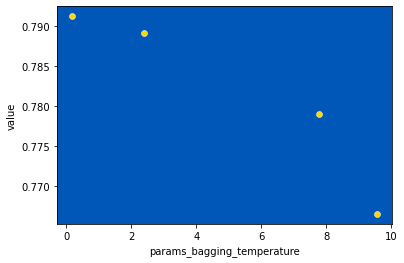

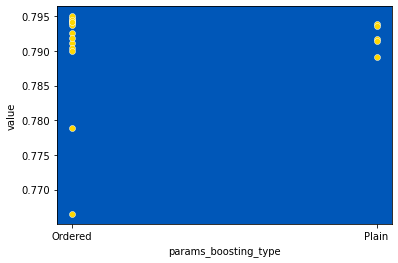

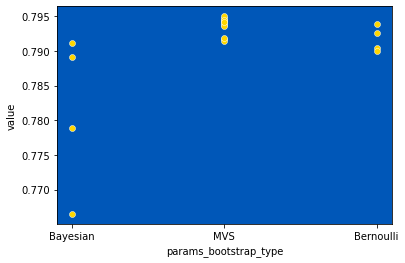

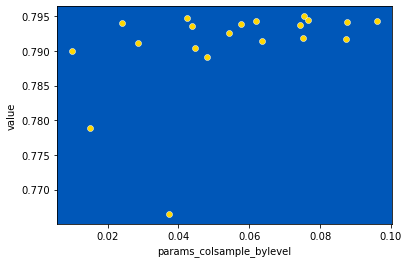

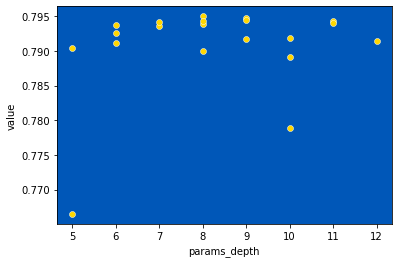

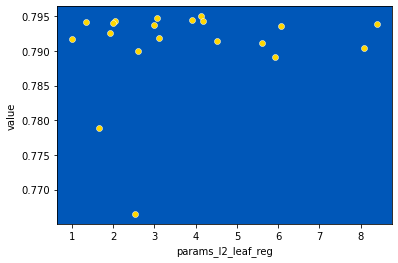

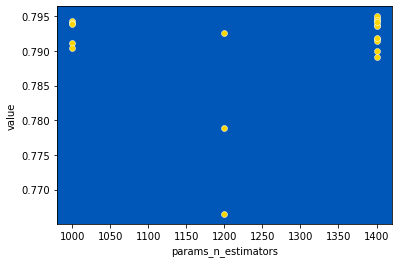

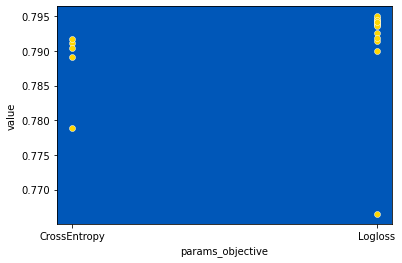

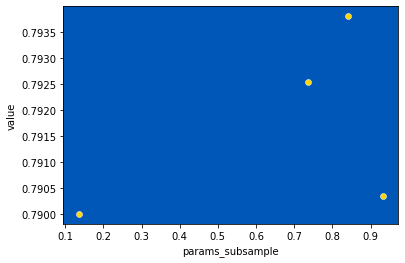

In [101]:
for col in get_cols(study_df, "params"):
    sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"])
    plt.show()